## 07: Introduction to Neural Networks


### What is a Neural Network?

#### Remark 1

Remember that the formula for linear regression can be written as

$$
\hat{y} = w x^{\intercal} + b
$$

where $\hat{y}$ is the predicted value, $w \in \mathbb{R}^d$ is one parameter, $x\in \mathbb{R}^d$ is the input, and $b \in \mathbb{R}$ is the bias, another parameter.

Note also that $w x^{\intercal} = \sum_{i=1}^d w_i x_i$, it is the scalar product of the vectors $w$ and $x$.

#### Remark 2

From what we saw in previous classes, changing the dimensions of the input in different stages (via a scikit-learn pipeline, for instance), helps improve the performance of the model.

![image](images/pipe.png)

The previous pipeline, converted each text input:

1. First into a vector of ~3000 dimensions (the number of words in the vocabulary)
2. Then into a vector of 50 dimensions (via PCA)
3. Finally, the output vector is the number of classes.


### Can we combine the previous two ideas?

Totally, **we can stack linear regressions**, one after the other, in which the output of the previous one is the input of the next one.

For example, let's suppose our input $x$ has 1000 dimensions. Then, we want to convert it to a vector of 50 dimensions, and then to a vector of 10 dimensions (the number of classes).

That is, we want to go: $\mathbb{R}^{1000} \rightarrow \mathbb{R}^{50} \rightarrow \mathbb{R}^{10}$. 

So we can do:

$$
h_1 = W_1 x + b_1 \\

y = W_2 h_1 + b_2
$$

Note the shapes of each element:

* $x \in \mathbb{R}^{1000}$
* $W_1 \in \mathbb{R}^{50 \times 1000}$
* $b_1 \in \mathbb{R}^{50}$
* $h_1 \in \mathbb{R}^{50}$

and in the second layer:

* $W_2 \in \mathbb{R}^{10 \times 50}$
* $b_2 \in \mathbb{R}^{10}$

thus finally leading to $y \in \mathbb{R}^{10}$.

**Question** What is the problem with the previous model?

I.e., can you simplify the expressions?

If we substitute the first equation into the second one, we get:

$$
y = W_2 (W_1 x + b_1) + b_2
$$

which is equivalent to:

$$
y = W_2 W_1 x + W_2 b_1 + b_2
$$

which can be rewritten as:

$$
y = W x + b
$$

where $W = W_2 W_1$ and $b = W_2 b_1 + b_2$.

**So even the fact that we have two layers, we can still write the model as a linear regression! We have nothing new...**

### Our first neural network 🧠

The solution to the previous problem is to add a **non-linear function** between the two layers. This function is called the **activation function**, and is tipycally denoted by the sigma letter $\sigma$.

So, our model becomes:

$$
h_1 = W_1 x + b_1 \\
z_2 = \sigma(h_1) \\
y = W_2 z_2 + b_2
$$

where $\sigma$ is the activation function.

Now, since we have added a non-linear function, we cannot simplify the expressions as before. So, we have a new model! **And because of the two layers, and the non-linear activation function, this model is much more flexible and powerful than linear regression.**

Here is the list of the most common activation functions:

![image](images/activations.png)

### An example of activation function in pytorch

Nowadays, the most common activation function is the **rectified linear unit** (ReLU). In pytorch, all the activation functions are defined here: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

In [1]:
import torch
import torch.nn as nn  # this already has functions defined for us.

In [2]:
x = torch.tensor([1, 2, 3, 4, -1, -2, -3, -4])

h = nn.ReLU()(x)

print(h)

tensor([1, 2, 3, 4, 0, 0, 0, 0])


In [3]:
# We can also use the functional API to do the same thing.

h = nn.functional.relu(x)

print(h)

tensor([1, 2, 3, 4, 0, 0, 0, 0])


#### Why the ReLU?

Though the activation function is an hyperparameter of the model, the ReLU is the most commonly used today. 

**The reason is that it is very cheap to compute (compared with the others), as it only requires to check if the input is positive or negative.**

In the end, what we care about in a neural network is that it can compute the transformations as fast as possible, so that we can train it in a reasonable amount of time.

### Defining neural networks in pytorch

Our previous NN model:

$$
h_1 = W_1 x + b_1 \\
z_2 = \sigma(h_1) \\
y = W_2 z_2 + b_2
$$

corresponds to the following pytorch code:

```python
import torch
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(1000, 50)  # the shapes of the W_1 matrix
        self.linear2 = nn.Linear(50, 10) # the shapes of the W_2 matrix
        self.activation = nn.ReLU() # our non-linear activation function
        
    def forward(self, x):
        h1 = self.linear1(x)
        z2 = self.activation(h1)
        y = self.linear2(z2)
        return y
```

In pytorch, neural networks are implemented as classes, that have two methods:

* `__init__`: where we define the layers of the network
* `forward`: where we define the how the layers are computed, that is, the flow of the network

**Note that we do not need to define the parameters $W_1, W_2, b_1, b_2$ explicitly, as they are included in the `nn.Linear` layers!**

That is, pytorch already knows that the `nn.Linear` layers have parameters, and that they need to be trained. Also, the library contains implementations for the most useful layers. The full list of layers can be seen here:

https://pytorch.org/docs/stable/nn.html


### Training neural networks

The training of neural networks is very similar to the training of linear regression models. Note that:

* The layers (linear) are differentiable, so we can compute the gradients.
* The activation functions are differentiable, so we can compute the gradients.

So we only need 

* some training dataset 
* a loss function (the same as in linear regression or logistic regression), 
* and an optimizer (gradient descent).

In the case of deep learning, gradient descent (and some variants of it) is the most popular optimizer. The reason is that it is very simple to implement, it only requires first-order derivatives, and it works well in practice for neural networks.

> Reminder from Gradient Descent in Session 3.

Fortunately, pytorch already implements gradient descent for us, so we can simply use it as follows:

```python
import torch.optim as optim

model = NeuralNetwork()
optimizer = optim.SGD(model.parameters(), lr=0.01)
```

* SGD stands for Stochastic Gradient Descent, which is the most common variant of gradient descent used in neural networks. It is **stochastic** because it uses a random subset of the training data to compute the gradients at each iteration.
* `lr`  is the learning rate (step size) of gradient descent. Remember that sometimes it has to be manually tuned.


Now, let's go back to code to see how can we implement all of this.

### Review: linear regression in the old way

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

This is our training dataset...

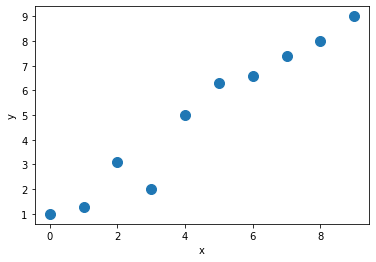

In [5]:
X_train = np.arange(10, dtype='float32').reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 
                    7.4, 8.0, 9.0], dtype='float32')

plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')

plt.show()

We normalize the data before, and convert to pytorch tensors.

In [6]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)
y_train = torch.from_numpy(y_train).float()

**New!** In Pytorch we also have DataLoader, which is a class that helps us to iterate over the data in mini-batches of a subset of examples



In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(X_train_norm, y_train)

batch_size = 1  # we want to iterate over all samples, one by one
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [8]:
# now, we can get a batch of samples from the data loader, using a for loop:
for x, y in train_dl:
    print('example:', x, 'target:', y)

example: tensor([[-1.5667]]) target: tensor([1.])
example: tensor([[1.2185]]) target: tensor([8.])
example: tensor([[0.8704]]) target: tensor([7.4000])
example: tensor([[0.1741]]) target: tensor([6.3000])
example: tensor([[-0.1741]]) target: tensor([5.])
example: tensor([[1.5667]]) target: tensor([9.])
example: tensor([[-0.8704]]) target: tensor([3.1000])
example: tensor([[-0.5222]]) target: tensor([2.])
example: tensor([[0.5222]]) target: tensor([6.6000])
example: tensor([[-1.2185]]) target: tensor([1.3000])


Now, we can define our linear regression manually, writing all the parameters and the loss function:

In [9]:
torch.manual_seed(1)
weight = torch.randn(1, requires_grad=True)
bias = torch.zeros(1, requires_grad=True)

# the loss function is defined as the mean squared error (regression)
def loss_fn(input, target):
    return (input-target).pow(2).mean()

def model(xb):
    return xb @ weight + bias

learning_rate = 0.001
num_epochs = 200  # an epoch is an iteration over the entire dataset
log_epochs = 10  # each log_epochs, we print the loss

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()

        with torch.no_grad():
            weight -= weight.grad * learning_rate
            bias -= bias.grad * learning_rate
            weight.grad.zero_()
            bias.grad.zero_()
 
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 45.0782
Epoch 10  Loss 26.4366
Epoch 20  Loss 1.5918
Epoch 30  Loss 14.1307
Epoch 40  Loss 11.6038
Epoch 50  Loss 6.3084
Epoch 60  Loss 0.6349
Epoch 70  Loss 3.1374
Epoch 80  Loss 1.9999
Epoch 90  Loss 0.3133
Epoch 100  Loss 0.7653
Epoch 110  Loss 1.0039
Epoch 120  Loss 0.0235
Epoch 130  Loss 0.5176
Epoch 140  Loss 0.0759
Epoch 150  Loss 1.8789
Epoch 160  Loss 0.0008
Epoch 170  Loss 0.0866
Epoch 180  Loss 0.0646
Epoch 190  Loss 0.0011


We plot our fitted model...

Final Parameters: 2.6696107387542725 4.879678249359131


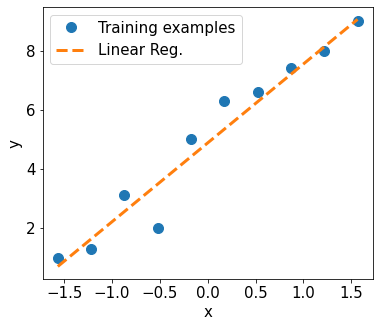

In [10]:
print('Final Parameters:', weight.item(), bias.item())
 
X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
 

plt.show()

### Model training via the torch.nn and torch.optim modules

With these subpackages of pytorch, we can write less code to fit our linear regression!

In [11]:
class LinearRegression(nn.Module):

    def __init__(self, input_dim):
        super(LinearRegression, self).__init__()
        self.lin = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.lin(x)

In [12]:
import torch.nn as nn

input_size = 1 # since we have only one feature (a scalar)
model = LinearRegression(input_size)

# loss function for regression is mean squared error
loss_fn = nn.MSELoss(reduction='mean')

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        # 1. Generate predictions
        pred = model(x_batch)

        # 2. Calculate loss
        loss = loss_fn(pred, y_batch)

        # 3. Compute gradients
        loss.backward()

        # 4. Update parameters using gradients
        optimizer.step()

        # 5. Reset the gradients to zero
        optimizer.zero_grad()
        
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

/Users/victorgallego/miniforge3/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/victorgallego/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0  Loss 24.6684
Epoch 10  Loss 29.1377
Epoch 20  Loss 20.9207
Epoch 30  Loss 0.1257
Epoch 40  Loss 12.4922
Epoch 50  Loss 1.7845
Epoch 60  Loss 7.6425
Epoch 70  Loss 2.5606
Epoch 80  Loss 0.0157
Epoch 90  Loss 0.7548
Epoch 100  Loss 0.8412
Epoch 110  Loss 0.4923
Epoch 120  Loss 0.0823
Epoch 130  Loss 0.0794
Epoch 140  Loss 0.0891
Epoch 150  Loss 0.0973
Epoch 160  Loss 0.1043
Epoch 170  Loss 0.1103
Epoch 180  Loss 0.0009
Epoch 190  Loss 0.0764


**Note that now we have to write less in the previous cell..**

Final Parameters: 2.6496422290802 4.87706995010376


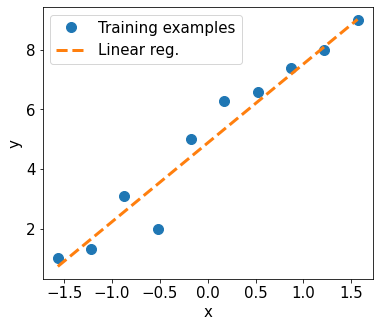

In [13]:
print('Final Parameters:', model.lin.weight.item(), model.lin.bias.item())
 
X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm.detach().numpy(), y_train.detach().numpy(), 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
 
plt.show()

**Question**: Why the final parameter values are not the same as the ones we obtained in the earlier example?

## Building a neural network for classifying flowers in the Iris dataset

Now, let's move to a classification example, using a well-known dataset: the Iris dataset.

Firstly, we load the data and split it into training and test sets.

In [14]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 

iris = load_iris()
X = iris['data']
y = iris['target']
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

We normalize the data as before, convert to pytorch tensors and create a DataLoader.

In [15]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train) 

train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

**Note** Now the batch_size is 2, so each time we iterate over the data, we get 2 examples:

In [16]:
for x, y in train_dl:
    print('x:', x, 'y:', y)
    break

x: tensor([[ 1.1447, -0.4353,  0.0234, -1.2507],
        [ 0.8899,  0.0234, -0.9959, -1.6585]]) y: tensor([1, 0])


Now, let's define our neural network, using two linear layers.

**New**: since this is a 3-class classification problem, note we introduce one final activation function, which is the softmax. This function converts its input into a probability distribution, so that the sum of all the elements is 1.

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)  # normalize so the dimensions of the output vector sum to 1
        return x

In [18]:
# an example of what the softmax function does:

x = torch.tensor([1., 2, 3])

y = nn.Softmax(dim=0)(x)

print(y)

tensor([0.0900, 0.2447, 0.6652])


This means that the first component is transformed into 9% probability, the second into 24%, and the final one into 67% probability.

In [19]:
x = torch.tensor([-10., -10, 10])

y = nn.Softmax(dim=0)(x)

print(y)

tensor([2.0612e-09, 2.0612e-09, 1.0000e+00])


This means that the first component is transformed into ~0% probability, the second into  ~0%, and the final one into ~100% probability.

**In classification problems, if we use the softmax as the final activation function, then we can interpret the output as the probabilities of belonging to each class**

Now, we define all the shapes: 
* The first layer, has 4 inputs (the number of features in the dataset), and 16 outputs.
* The second layer, has 16 inputs (the number of outputs of the previous layer), and 3 outputs (the number of classes).

In [20]:
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
 
model = NeuralNetwork(input_size, hidden_size, output_size)

learning_rate = 0.01

# this is the loss function for classification with softmax
loss_fn = nn.CrossEntropyLoss()
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [21]:
num_epochs = 100
# these lists are used for logging later and plotting the results.
loss_hist = [0] * num_epochs  
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

Let's plot how the loss value changes over training time.
And also how the (training) accuracy changes over training time.

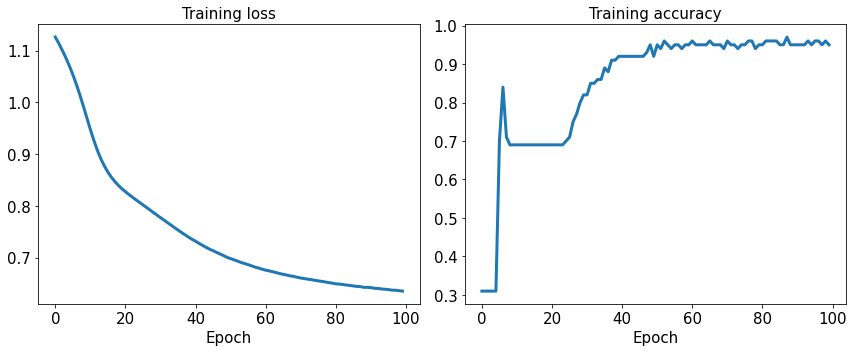

In [22]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

 
plt.show()

* The spikes you can see in the accuracy plot are the result of the stochastic part in gradient descent. Since at each iteration we use a random subset of the training data, the accuracy can go up and down, depending on how "hard" or "easy" are the examples of that batch.

Now, let's compute predictions over the test set, and compute the accuracy.

In [23]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test) 
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


**Exercise 1**: Which test accuracy you get when using a logistic regression (in pytorch)?

In [28]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(4, 3)  
        
        
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Softmax(dim=1)(x)  # normalize so the dimensions of the output vector sum to 1
        return x

In [29]:
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
 
model = LogisticRegression()

learning_rate = 0.01

# this is the loss function for classification with softmax
loss_fn = nn.CrossEntropyLoss()
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [30]:
num_epochs = 100
# these lists are used for logging later and plotting the results.
loss_hist = [0] * num_epochs  
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

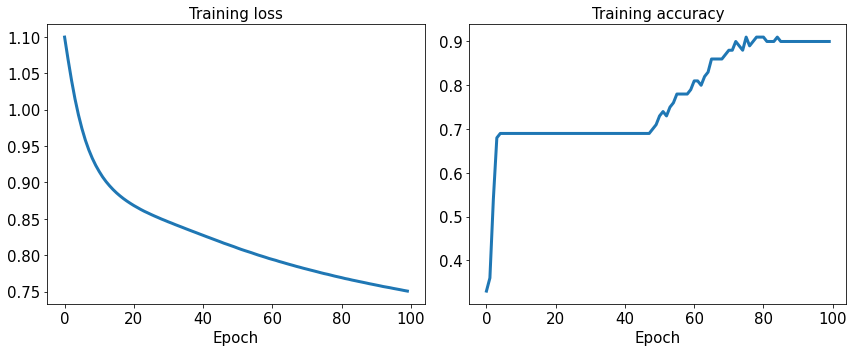

In [31]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

 
plt.show()

In [33]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = y_test 
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9400


### Useful things with pytorch


**1. Model examination**

Just print the model object and you will see the structure of the model, with all the dimensions of the parameters.*

In [27]:
model

NeuralNetwork(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [34]:
model

LogisticRegression(
  (layer1): Linear(in_features=4, out_features=3, bias=True)
)

**2. Saving the model to disk**

Useful to save the model automatically after a training run, so that you can use it later.

In [35]:
torch.save(model.state_dict(), "model.bin")

**3. Loading the model from disk**

First, you have to instantiate the model class, then load the parameters from disk.

In [37]:
model = LogisticRegression()
model.load_state_dict(torch.load("model.bin"))

<All keys matched successfully>

### Concluding remarks

**A (feed-forward) neural network is just a mathematical function that takes some input vector (the features of our data), and then progressively transforms it, chaning the dimensions by applying several layers (linear transformations + non-linear activation functions) sequentially, until producing the final output (the prediction).**

This is an example of the diagram of a neural network:

![image](images/nn.jpg)